In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

In [2]:
raw_data = pd.read_csv('intro_ml_workshop_dataset.csv')
raw_data.head()

ds        power  wetbulb_temperature   humidity
0  2023-06-27 17:08:00  2088.999031               88.385  67.695832
1  2023-06-27 17:09:00  2089.850510               88.460  68.916667
2  2023-06-27 17:10:00  2086.172455               88.295  68.816667
3  2023-06-27 17:11:00  2091.607552               88.280  69.025000
4  2023-06-27 17:12:00  2085.903702               87.905  68.279167

In [3]:
df = raw_data.copy()
df.shape

(47622, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47622 entries, 0 to 47621
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ds                   47622 non-null  object 
 1   power                47622 non-null  float64
 2   wetbulb_temperature  43269 non-null  float64
 3   humidity             47608 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.5+ MB


### EDA

In [5]:
fig = px.line(df, x='ds', y='power', title='Power Consumption Over Time')
fig.show()

จะสังเกตุว่าข้อมูลในช่วงเวลา 2023-07-06 14:49:00 - 2023-07-25 13:25:00 หายไปเลยจะทำการตัดข้อมูลให้เริ่มตั้งแต่ช่วงถัดจาก 2023-07-25 13:25:00 แทน

In [6]:
# Define the timestamp
target_timestamp = '2023-07-25 13:25:00'
# Find index where 'ds' equals the target timestamp
index = df[df['ds'] == target_timestamp].index[0]
print("Index at '2023-07-25 13:25:00':", index)

Index at '2023-07-25 13:25:00': 7584


In [7]:
df = df.iloc[7585:]
fig = px.line(df, x='ds', y='power', title='Power Consumption Over Time')
fig.show()

เมื่อสังเกตุจะพบว่าช่วงเวลา 06:00 - 18:00 ของทุกวันจะมีการใช้ power สูงสุดในวันนั้นๆ และวันเสาร์ อาทิตย์จะมีการใช้ power ที่ต่ำกว่าวันจันทร์-ศุกร์

In [8]:
fig = px.line(df, x='ds', y=['wetbulb_temperature','humidity'], title='Power Consumption Over Time')
fig.show()

In [9]:
# Convert 'ds' to datetime
df['ds'] = pd.to_datetime(df['ds'])
# Create more feature
# Month for impute NaN with mean each Month
# Golden_hours at 06:00 - 18:00
# Day_of_week Sat,Sun use low power
df['Day_of_week'] = df['ds'].dt.day_of_week
df['Golden_hours'] = (df['ds'].dt.hour >= 6) & (df['ds'].dt.hour < 18).astype(int)
df['Month'] = df['ds'].dt.month

In [10]:
df.head()

ds        power  wetbulb_temperature   humidity  \
7585 2023-07-25 14:22:00  1995.424927               85.955  71.508334   
7586 2023-07-25 14:23:00  1994.791473               86.000  71.505001   
7587 2023-07-25 14:24:00  1979.656555               86.060  71.629171   
7588 2023-07-25 14:25:00  1983.656166               86.090  71.558333   
7589 2023-07-25 14:26:00  1988.359406               85.850  71.170832   

      Day_of_week  Golden_hours  Month  
7585            1          True      7  
7586            1          True      7  
7587            1          True      7  
7588            1          True      7  
7589            1          True      7

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40037 entries, 7585 to 47621
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   40037 non-null  datetime64[ns]
 1   power                40037 non-null  float64       
 2   wetbulb_temperature  36226 non-null  float64       
 3   humidity             40027 non-null  float64       
 4   Day_of_week          40037 non-null  int64         
 5   Golden_hours         40037 non-null  bool          
 6   Month                40037 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2)
memory usage: 1.9 MB


In [12]:
# replace humidity NaN with mean
df['humidity'] = np.where(df['humidity'].isnull(),df['humidity'].mean(),df['humidity'])

In [13]:
#find average of wetbulb_temperature by Month
grouped = df.groupby('Month')['wetbulb_temperature']
wetbulb_temperature_avg_M7 = grouped.mean()[7]
wetbulb_temperature_avg_M8 = grouped.mean()[8]

In [14]:
# replace wetbulb_temperature NaN with each mean
df['wetbulb_temperature'] = np.where((df['Month']==7)&df['wetbulb_temperature'].isnull(),wetbulb_temperature_avg_M7,df['wetbulb_temperature'])
df['wetbulb_temperature'] = np.where((df['Month']==8)&df['wetbulb_temperature'].isnull(),wetbulb_temperature_avg_M8,df['wetbulb_temperature'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40037 entries, 7585 to 47621
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   40037 non-null  datetime64[ns]
 1   power                40037 non-null  float64       
 2   wetbulb_temperature  40037 non-null  float64       
 3   humidity             40037 non-null  float64       
 4   Day_of_week          40037 non-null  int64         
 5   Golden_hours         40037 non-null  bool          
 6   Month                40037 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2)
memory usage: 1.9 MB


###Model

In [16]:
df.head()

ds        power  wetbulb_temperature   humidity  \
7585 2023-07-25 14:22:00  1995.424927               85.955  71.508334   
7586 2023-07-25 14:23:00  1994.791473               86.000  71.505001   
7587 2023-07-25 14:24:00  1979.656555               86.060  71.629171   
7588 2023-07-25 14:25:00  1983.656166               86.090  71.558333   
7589 2023-07-25 14:26:00  1988.359406               85.850  71.170832   

      Day_of_week  Golden_hours  Month  
7585            1          True      7  
7586            1          True      7  
7587            1          True      7  
7588            1          True      7  
7589            1          True      7

In [17]:
# Time series must not shuffle data
# Calculate the index for splitting
split_index = int(len(df) * 0.8)
# Split the DataFrame into training and testing sets
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

In [18]:
# Create Random Forest Regressor instance
rf_regressor = RandomForestRegressor(n_estimators=200,min_samples_split=5, min_samples_leaf=2,max_depth=4)
# train test split
X_train = train_df[['wetbulb_temperature','humidity','Day_of_week','Golden_hours']]
y_train = train_df['power']
X_test = test_df[['wetbulb_temperature','humidity','Day_of_week','Golden_hours']]
y_test = test_df['power']
# Fit the regressor to your data
rf_regressor.fit(X_train,y_train)

RandomForestRegressor(max_depth=4, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200)

Model Evaluation metrics

In [19]:
# Prediction
y_pred = rf_regressor.predict(X_test)
# Calculate Root Mean Squared Error
rmse = mean_squared_error(y_test, y_pred, squared=False)
# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared:", r_squared)

Root Mean Squared Error: 277.6897565285012
Mean Absolute Error: 208.00919013731942
R-squared: 0.8620686987839068


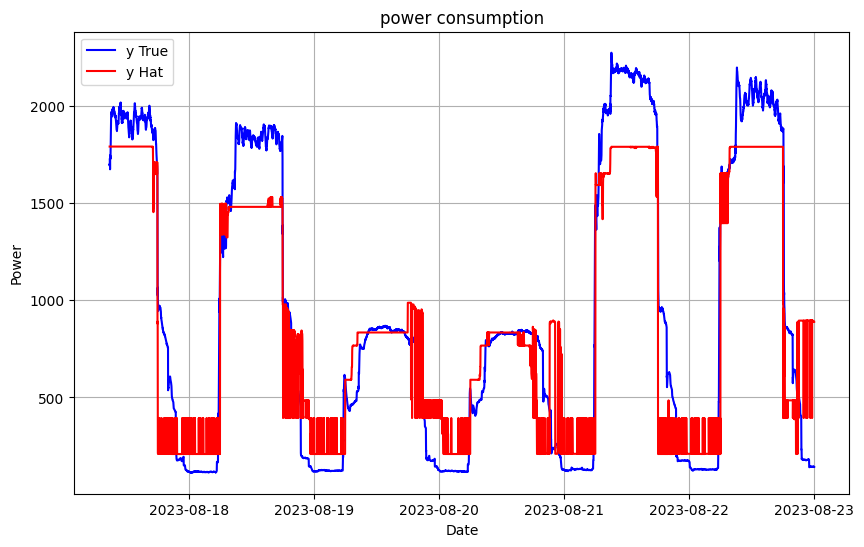

In [20]:
plt.figure(figsize=(10, 6))  # Set the figure size
# Plot the first line
plt.plot(test_df['ds'], test_df['power'], label='y True', color='blue')
# Plot the second line
plt.plot(test_df['ds'], y_pred, label='y Hat', color='red')
# Add labels and title
plt.xlabel('Date')
plt.ylabel('Power')
plt.title('power consumption')
# Add legend
plt.legend()
# Show plot
plt.grid(True)
plt.show()

In [25]:
last_timestamp = df['ds'].iloc[-1]
# Add 1 day to the last timestamp to get the timestamp for the next day
next_day_timestamp = last_timestamp + pd.Timedelta(days=1)
# Prepare input features for the next day (assuming you have wetbulb_temperature and humidity data)
next_day_features = {
    'wetbulb_temperature': 86.090	,  # Provide the value for the next day's wetbulb_temperature
    'humidity': 71.629171,
    'Day_of_week': 2,
    'Golden_hours': 0
}
# Create a DataFrame with input features for the next day
next_day_df = pd.DataFrame([next_day_features])
# Display the DataFrame with input features for the next day
print(next_day_df)

   wetbulb_temperature   humidity  Day_of_week  Golden_hours
0                86.09  71.629171            2             0


In [26]:
# Use the trained model to predict power values for the next day
predicted_power = rf_regressor.predict(next_day_df)
# Display the predicted power values
print("Predicted power values for the next day:", predicted_power)

Predicted power values for the next day: [986.7438443]


จะพบว่ามีค่า power ที่ต่ำเนื่องจากเป็นช่วงเวลาที่ไม่อยู่ใน Golden_hours